In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lib.functions_data import ordered_countries_original, ordered_countries_new, is_ongoing, zero_out_dict

In [2]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
usecols=['eudract_number', 'nca', 'entered_year', 'trial_status']
status_df = pd.read_csv(parent + '/data/analysis_df_jul22.csv', usecols = usecols)
status_df['trial_status'] = status_df.trial_status.fillna('Missing')

status_group = status_df.groupby(['nca', 'entered_year', 'trial_status'], as_index=False).count()

In [4]:
ordered_countries = list(status_group[['nca', 'eudract_number']].groupby('nca').sum().sort_values(by='eudract_number', ascending=False).index)

#Removing these for low number of trials
ordered_countries.remove('Malta - ADM')
ordered_countries.remove('Luxembourg - Ministry of Health')
ordered_countries.remove('Cyprus - MoH-Ph.S')

In [31]:
ordered_countries

['UK - MHRA',
 'Italy - AIFA',
 'Spain - AEMPS',
 'Germany - BfArM',
 'France - ANSM',
 'Netherlands - CCMO',
 'Belgium - FAMHP',
 'Hungary - OGYEI',
 'Czechia - SUKL',
 'Denmark - DKMA',
 'Austria - BASG',
 'Sweden - MPA',
 'Poland - URPL',
 'Germany - PEI',
 'Finland - FIMEA',
 'Bulgaria - BDA',
 'Greece - EOF',
 'Slovakia - SUKL',
 'Portugal - INFARMED',
 'Lithuania - VVKT',
 'Ireland - HPRA',
 'Latvia - ZVA',
 'Estonia - SAM',
 'Norway - NoMA',
 'Romania - ANMDM',
 'Croatia - MIZ',
 'Slovenia - JAZMP',
 'Iceland - IMA']

In [5]:
#Collapsing the various trial status categories on the EUCTR into simpler categories
country_status = {}

for c in status_group.nca.unique():
    country_dict = {}
    country = status_group[status_group.nca == c]
    
    completed = country[country.trial_status.isin(['Completed', 'Prematurely Ended'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    comp_dict = completed.to_dict()['eudract_number']
    country_dict['completed'] = zero_out_dict(comp_dict, range(2004,2021))
    
    ongoing = country[country.trial_status.isin(['Ongoing', 'Restarted'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    ong_dict = ongoing.to_dict()['eudract_number']
    country_dict['ongoing'] = zero_out_dict(ong_dict, range(2004,2021))
    
    missing = country[country.trial_status == 'Missing']
    missing_dict = pd.Series(missing.eudract_number.values, index=missing.entered_year).to_dict()
    country_dict['missing'] = zero_out_dict(missing_dict, range(2004,2021))
    
    other = country[~country.trial_status.isin(['Completed', 'Ongoing', 'Restarted', 'Prematurely Ended', 'Missing'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    other_dict = other.to_dict()['eudract_number']
    country_dict['other'] = zero_out_dict(other_dict, range(2004,2021))
    
    country_status[c] = country_dict

In [6]:
#Shaping up the final data so it's easy to use

regrouped = pd.DataFrame.from_dict(country_status, orient='index').stack().to_frame()[0].apply(pd.Series).reindex(
    ['completed', 'ongoing', 'other', 'missing'], level=1)

# Overall Trend in Completion Status - Supplemental Figure 6

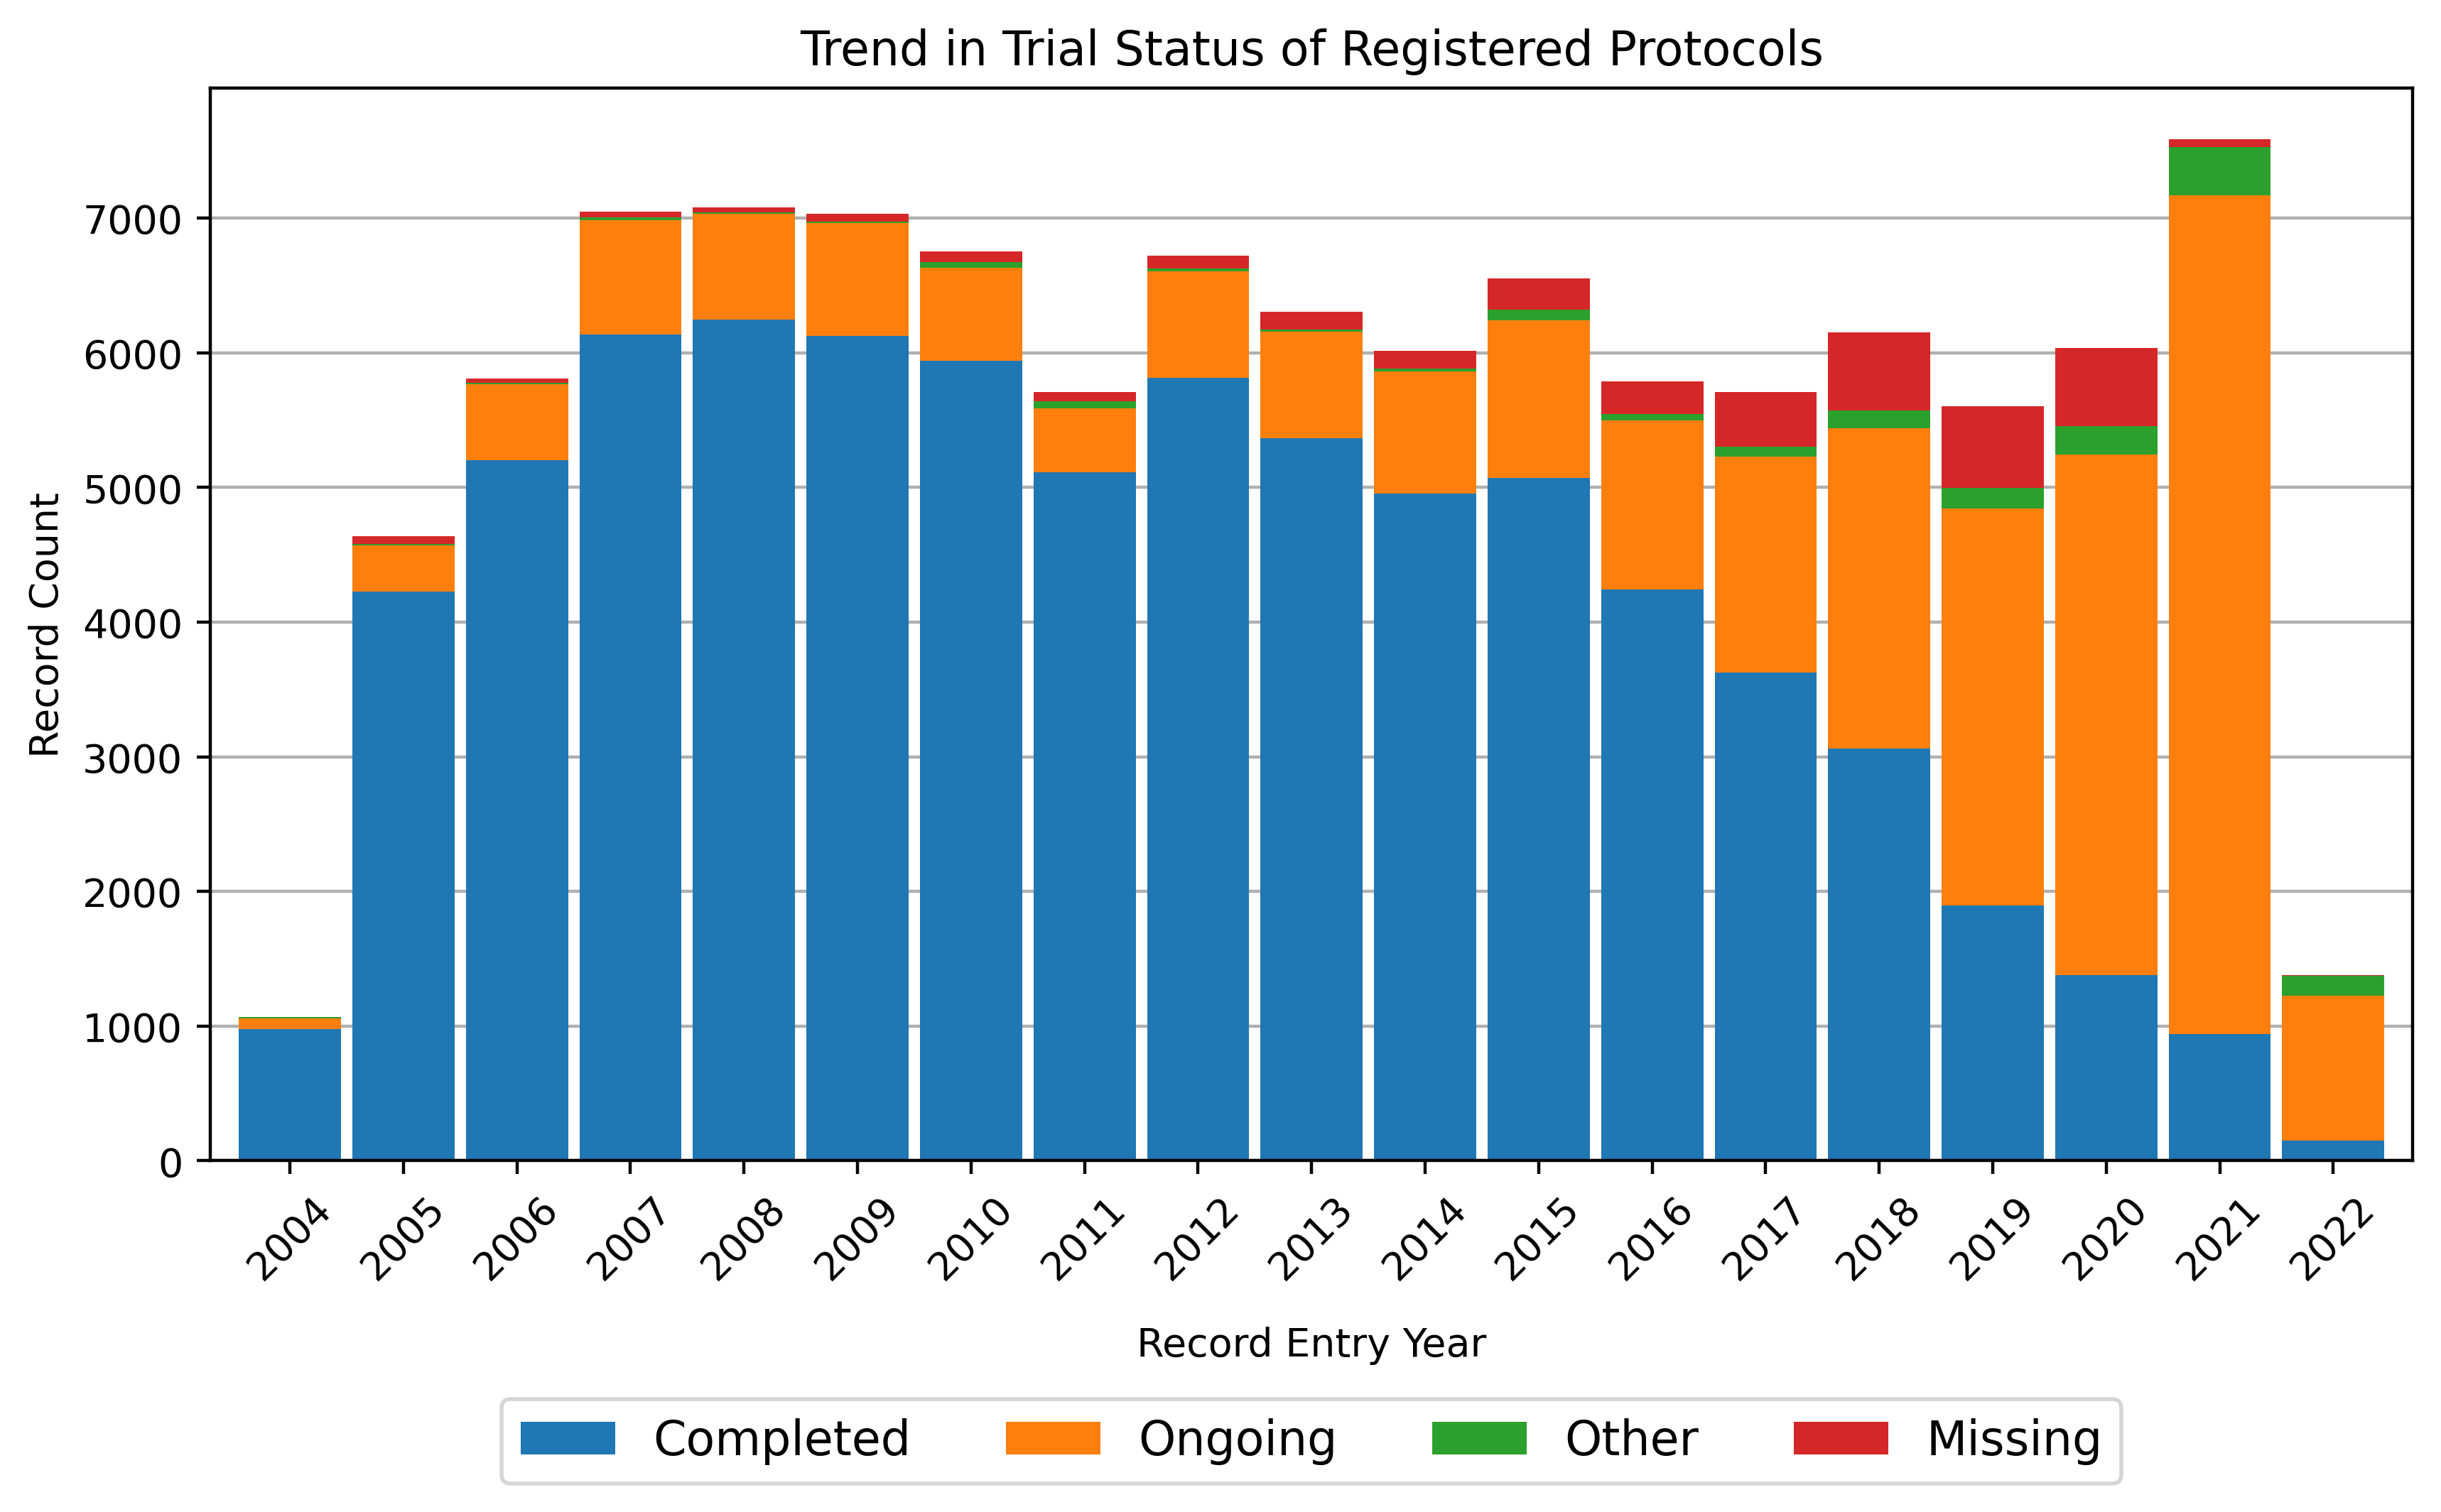

In [7]:
#A glance at the overall trend

grouped_total = regrouped.droplevel(level=0).groupby(regrouped.droplevel(level=0).index).sum()

title='Trend in Trial Status of Registered Protocols'


fig, ax = plt.subplots(figsize = (10,5), dpi=400)
grouped_total.reindex(['completed', 'ongoing', 'missing', 'other']).T.plot.bar(stacked=True, width=.9, ax=ax, 
                                                                               rot=45, title = title, 
                                                                               legend=False)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Record Entry Year', labelpad=10)
ax.set_ylabel('Record Count')

plt.legend(['Completed', 'Ongoing', 'Other', 'Missing'], 
           loc='upper center', ncol=5, bbox_to_anchor = (0.5, -0.2), fontsize=12)
plt.show()
#fig.savefig(parent + '/data/Figures/fig_s6.jpg', bbox_inches='tight', dpi=400)
#Saved

# Key Statistics

In [8]:
#What is the distribution of completed trials by year?

g_total = grouped_total.T
g_total['prct'] = round((g_total['completed'] / (g_total['ongoing'] + g_total['completed'] + g_total['missing'] + g_total['other'])) * 100,2)
g_total

completed  missing  ongoing  other   prct
2004      976.0      8.0     82.0    2.0  91.39
2005     4225.0     13.0    342.0   58.0  91.10
2006     5203.0     11.0    563.0   34.0  89.54
2007     6134.0     21.0    849.0   45.0  87.02
2008     6247.0      9.0    785.0   41.0  88.21
2009     6127.0     15.0    835.0   57.0  87.11
2010     5943.0     43.0    690.0   77.0  88.01
2011     5112.0     54.0    473.0   68.0  89.57
2012     5813.0     19.0    794.0   95.0  86.49
2013     5368.0     15.0    789.0  135.0  85.11
2014     4952.0     22.0    908.0  131.0  82.35
2015     5070.0     78.0   1172.0  234.0  77.36
2016     4243.0     49.0   1252.0  245.0  73.29
2017     3627.0     72.0   1601.0  408.0  63.54
2018     3063.0    134.0   2374.0  580.0  49.80
2019     1893.0    157.0   2949.0  605.0  33.78
2020     1379.0    214.0   3864.0  580.0  22.84
2021      942.0    355.0   6230.0   58.0  12.42
2022      151.0    149.0   1073.0    6.0  10.95

In [9]:
#What percent of all protocols are in a completed status

print(f'There are {grouped_total.sum(axis=1)["completed"]} completed protocols')
print(f'There are {grouped_total.sum(axis=1).sum()} total protocols')
print(f'{round((grouped_total.sum(axis=1)["completed"]/grouped_total.sum(axis=1).sum())*100,2)}% are completed')

There are 76468.0 completed protocols
There are 108990.0 total protocols
70.16% are completed


In [10]:
#What is the distribution of completed trials by country?

overall_prct_dict = {}

for x in ordered_countries:
    g = regrouped.loc[[x]].droplevel(level=0).T
    num = g.completed.sum()
    denom = num + g.ongoing.sum() + g.missing.sum() + g.other.sum()
    overall_prct_dict[x] = num / denom

rankings_completed = pd.Series(overall_prct_dict).sort_values(ascending=False)
rankings_completed

Estonia - SAM          0.881066
Latvia - ZVA           0.875436
Lithuania - VVKT       0.861573
Iceland - IMA          0.849624
Slovakia - SUKL        0.835462
Germany - BfArM        0.827040
Czechia - SUKL         0.803499
Austria - BASG         0.792342
Bulgaria - BDA         0.786158
Hungary - OGYEI        0.774903
Slovenia - JAZMP       0.756501
Ireland - HPRA         0.751364
Denmark - DKMA         0.745889
Belgium - FAMHP        0.739505
UK - MHRA              0.736799
Sweden - MPA           0.727513
Finland - FIMEA        0.725759
Greece - EOF           0.717520
Germany - PEI          0.701913
Portugal - INFARMED    0.697227
Poland - URPL          0.661043
Croatia - MIZ          0.644105
Spain - AEMPS          0.609301
Italy - AIFA           0.606465
France - ANSM          0.552576
Netherlands - CCMO     0.536910
Romania - ANMDM        0.508501
Norway - NoMA          0.483108
dtype: float64

In [11]:
print(f'{round((len(rankings_completed[rankings_completed > .652]) / len(rankings_completed)) * 100,2)}% of countried exceed the overall mark')

75.0% of countried exceed the overall mark


# Status trends for every country - Supplemental Figure 7

In [12]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=400)
fig.suptitle("Trial Status Trends by Country Regulator", y=1.02, fontsize=23)
fig.tight_layout()
for x, y in enumerate(fig.axes):
    regrouped.loc[[rankings_completed.index[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.85, 
                                                                               legend=False, sharex='col', rot=45)
    
    y.set_title(rankings_completed.index[x], pad=6, fontsize=16)
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('')
    
    hatches = ['','//', 'oo', '\\\\']
    counter = 0
    h_counter = 0
    patch_count = len(y.patches)
    for p in y.patches:
        p.set_hatch(hatches[h_counter])
        counter += 1
        if counter == ((patch_count/4) * (h_counter+1)):
            h_counter += 1
            

fig.text(-0.015, 0.5, 'Record Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.5, -0.025, 'Record Entry Year', ha='center', va='center', fontsize=20)

plt.legend(['Completed', 'Ongoing', 'Other', 'Missing'], 
           loc='upper center', ncol=5, bbox_to_anchor = (-1.2, -.55), fontsize=15)

plt.show()
fig.savefig(parent + '/data/Figures/fig_s7.jpg', bbox_inches='tight', dpi=400)
#Saved

# Figure 4a

Now limiting it just to the examples we are pulling out into the paper.

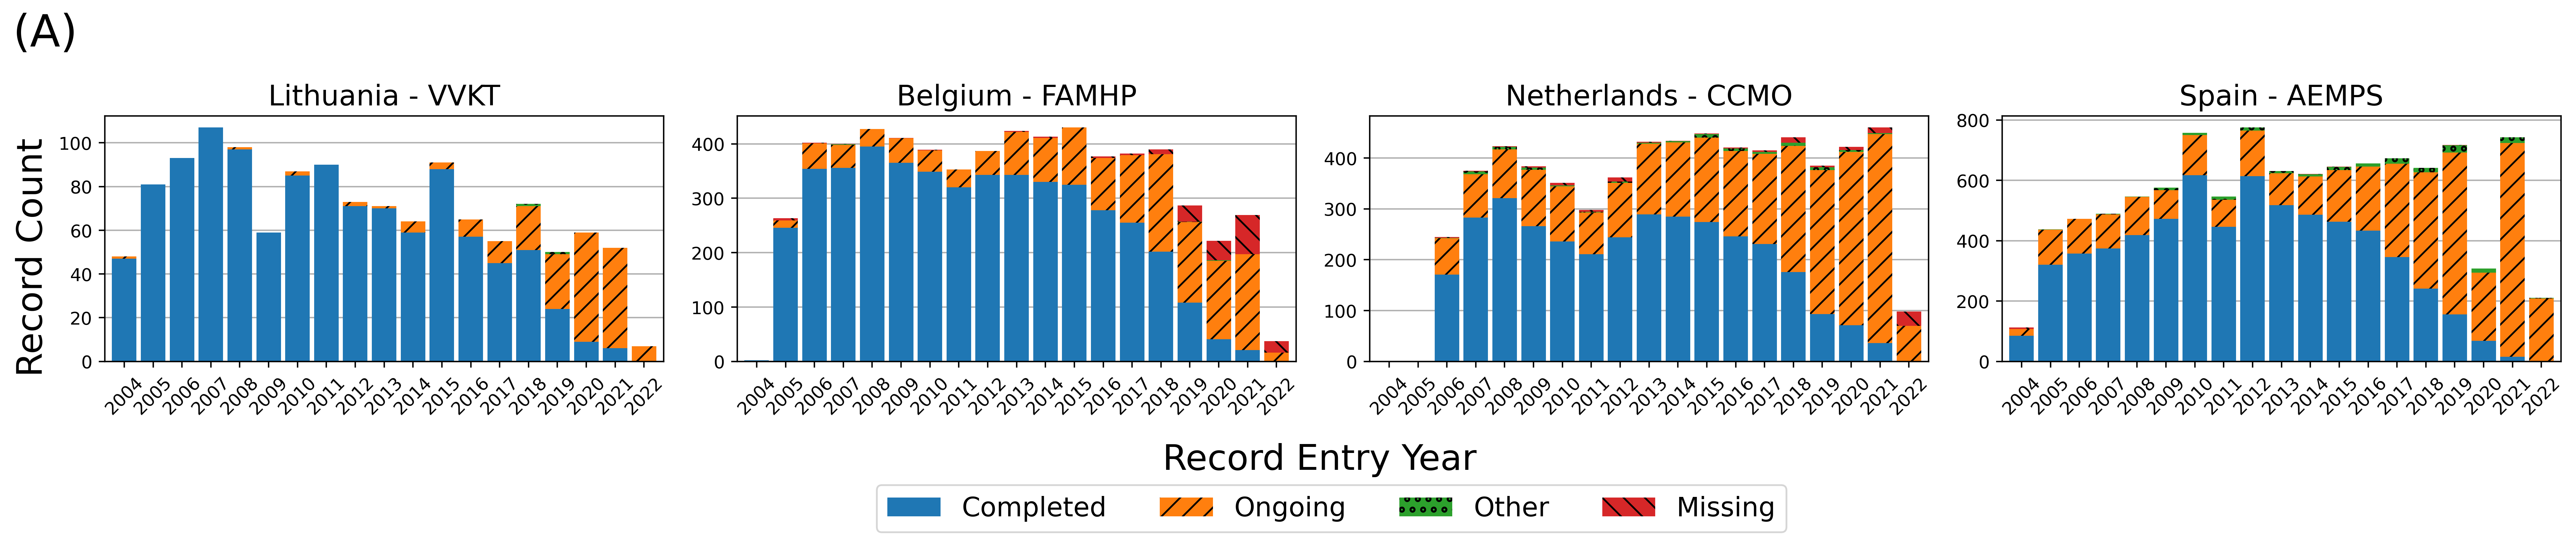

In [13]:
#Pull out the highlighted countries

fig, axes = plt.subplots(figsize = (20, 3), nrows=1, ncols=4, dpi=400)
fig.suptitle("(A)", y=1.04, x=0, fontsize=25)
fig.tight_layout()
included_countries = ['Lithuania - VVKT', 'Belgium - FAMHP', 'Netherlands - CCMO', 'Spain - AEMPS']

for x, y in enumerate(fig.axes):
    regrouped.loc[[included_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.85, 
                                                                               legend=False, sharex='col', rot=45)
    
    y.set_title(included_countries[x], pad=6, fontsize=16)
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('')
    
    hatches = ['','//', 'oo', '\\\\']
    counter = 0
    h_counter = 0
    patch_count = len(y.patches)
    for p in y.patches:
        p.set_hatch(hatches[h_counter])
        counter += 1
        if counter == ((patch_count/4) * (h_counter+1)):
            h_counter += 1
            

fig.text(-0.005, 0.4, 'Record Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.5, -0.13, 'Record Entry Year', ha='center', va='center', fontsize=20)

plt.legend(['Completed', 'Ongoing', 'Other', 'Missing'], 
           loc='upper center', ncol=5, bbox_to_anchor = (-1.2, -.45), fontsize=15)


plt.show()
#fig.savefig(parent + '/data/Figures/fig_4a.jpg', bbox_inches='tight', dpi=400)
#fig.savefig(parent + '/data/Figures/fig_4a.eps', bbox_inches='tight', dpi=400)
#Saved

# Stats on conflicting and problematic trial status data for the paper

In [14]:
status_df['trial_status'].value_counts()

Completed                   63502
Ongoing                     27293
Prematurely Ended           12966
GB - no longer in EU/EEA     2797
Missing                      1438
Temporarily Halted            520
Restarted                     332
Not Authorised                 76
Prohibited by CA               37
Suspended by CA                23
Trial now transitioned          6
Name: trial_status, dtype: int64

In [15]:
status_summary = status_df[['eudract_number', 'trial_status']].groupby('eudract_number')['trial_status'].count().to_frame(name='count').join(status_df[['eudract_number', 'trial_status']].groupby('eudract_number')['trial_status'].apply(list).to_frame(name='status'))
status_summary['set'] = status_summary['status'].apply(set)
multi_status = status_summary[status_summary['count'] > 1].reset_index().set_index('eudract_number')
indiv_status = multi_status['set'].to_list()

In [16]:
#This counts the number of trials that have an ongoing and a completed status

c = 0
indicator_var = []

#Looking for our "Ongoing" or "Completed" statuses
for i in indiv_status:
    if ('Ongoing' in i or 'Restarted' in i) and ('Completed' in i or 'Premautrely Ended' in i):
        c+=1
        indicator_var.append(1)
    else:
        indicator_var.append(0)
        
print(c)

1782


In [17]:
print(f'{round((c/len(indiv_status)) * 100,2)}% of multi-protocol trials are in a conflicted status')

11.5% of multi-protocol trials are in a conflicted status


In [18]:
group_year = status_df[['eudract_number', 'entered_year']].groupby('eudract_number').max()

multi_status['conflict'] = indicator_var

year_joined = multi_status.join(group_year, how='left')

year_joined.head()

count                                             status  \
eudract_number                                                             
2004-000012-13      3                  [Completed, Completed, Completed]   
2004-000015-25      4       [Completed, Completed, Completed, Completed]   
2004-000016-10      2                               [Completed, Ongoing]   
2004-000022-75      4       [Completed, Completed, Completed, Completed]   
2004-000023-15     14  [Completed, Completed, Completed, Completed, C...   

                                 set  conflict  entered_year  
eudract_number                                                
2004-000012-13           {Completed}         0          2007  
2004-000015-25           {Completed}         0          2005  
2004-000016-10  {Completed, Ongoing}         1          2004  
2004-000022-75           {Completed}         0          2006  
2004-000023-15           {Completed}         0          2008

In [19]:
conflict_summary = year_joined[['conflict', 'entered_year']].reset_index(drop=True).groupby('entered_year').agg(['sum', 'count'])

conflict_summary['prct'] = round((conflict_summary['conflict']['sum'] / conflict_summary['conflict']['count'])*100,2)

conflict_summary.head()

conflict        prct
                  sum count      
entered_year                     
2004                1    58  1.72
2005               19   468  4.06
2006               69   778  8.87
2007               68   828  8.21
2008               71   898  7.91

# Supplemental Figure 8

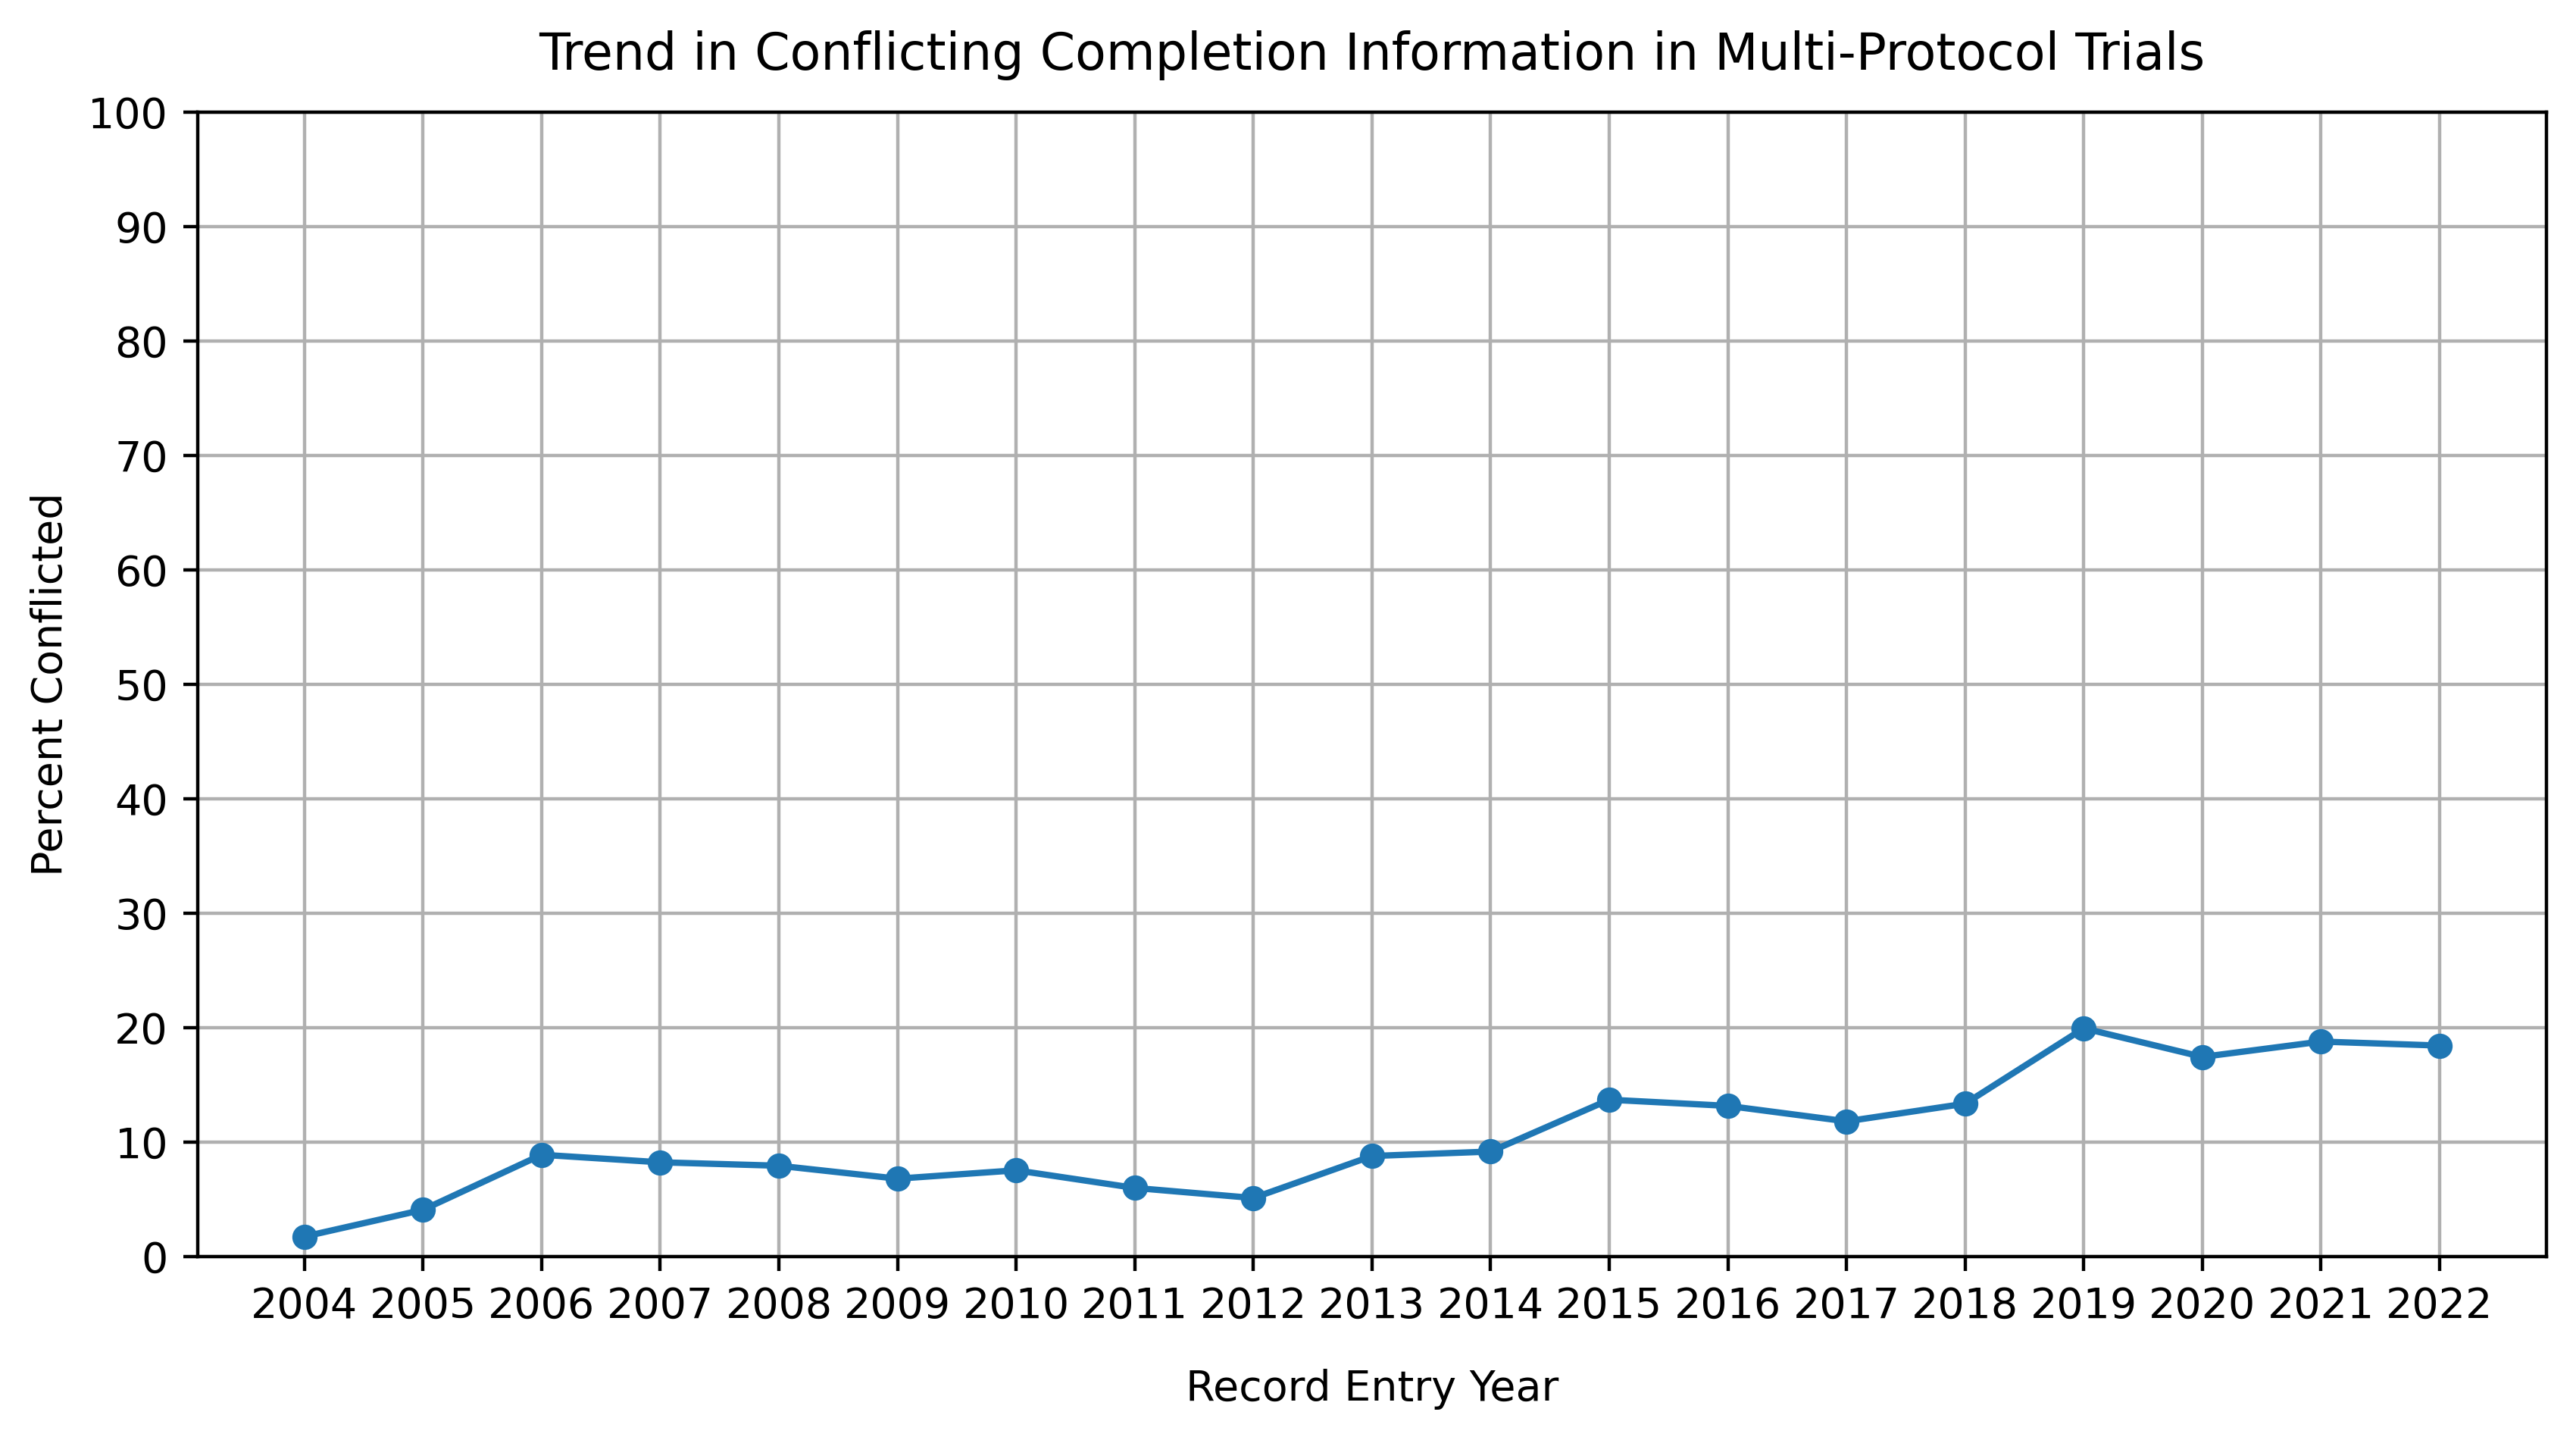

In [35]:
fig, ax = plt.subplots(figsize = (10,5), dpi=400)

plt.plot(conflict_summary.index, conflict_summary['prct'], marker='.', markersize=10)
plt.grid()
plt.xlabel('Record Entry Year', labelpad=10)
plt.ylabel('Percent Conflicted')
plt.title('Trend in Conflicting Completion Information in Multi-Protocol Trials', pad=10)

ax.set_yticks(range(0, 101,10))
ax.set_xticks(range(2004,2023))

plt.show()
#fig.savefig(parent + '/data/Figures/fig_s8.jpg', bbox_inches='tight', dpi=400)
#Saved

What about trials with only a single protocol?

In [21]:
single_status = status_summary[status_summary['count'] == 1].reset_index().set_index('eudract_number').join(status_df.set_index('eudract_number')[['entered_year']], how='left')

single_status['ongoing'] = single_status['status'].apply(is_ongoing)

In [22]:
single_s_grouped = single_status[['count', 'ongoing', 'entered_year']].groupby('entered_year').sum()

In [23]:
#How many trials from prior to 2015 are still in an ongoing status?
print(single_s_grouped[single_s_grouped.index < 2015].sum())
print(round((6086/16552)*100,2))

count      16565
ongoing     4924
dtype: int64
36.77


# Completion date availability trends

In [36]:
usecols=['eudract_number', 'nca', 'entered_year', 'trial_status', 'completion_date', 'trial_results']
date_df = pd.read_csv(parent + '/data/analysis_df_jul22.csv', usecols = usecols)
date_df['trial_status'] = date_df.trial_status.fillna('Missing')
date_df['has_completion_date'] = np.where(date_df.completion_date.isna(), 0, 1)
only_completed = date_df[date_df.trial_status.isin(['Completed', 'Prematurely Ended'])].reset_index(drop=True)

In [37]:
total_completed = only_completed[['nca', 
                                  'entered_year', 
                                  'has_completion_date']].groupby(['nca', 
                                                                   'entered_year']).count().rename({'has_completion_date': 'denominator'}, axis=1)

total_completed_date = only_completed[['nca', 'entered_year', 'has_completion_date']].groupby(['nca', 'entered_year']).sum().rename({'has_completion_date': 'numerator'}, axis=1)

In [38]:
merged_dates = total_completed.join(total_completed_date)
merged_dates['missing_dates'] = merged_dates.denominator - merged_dates.numerator

stacked_dates = merged_dates.drop('denominator', axis=1).stack().unstack(1)

# Supplemental Figure 9

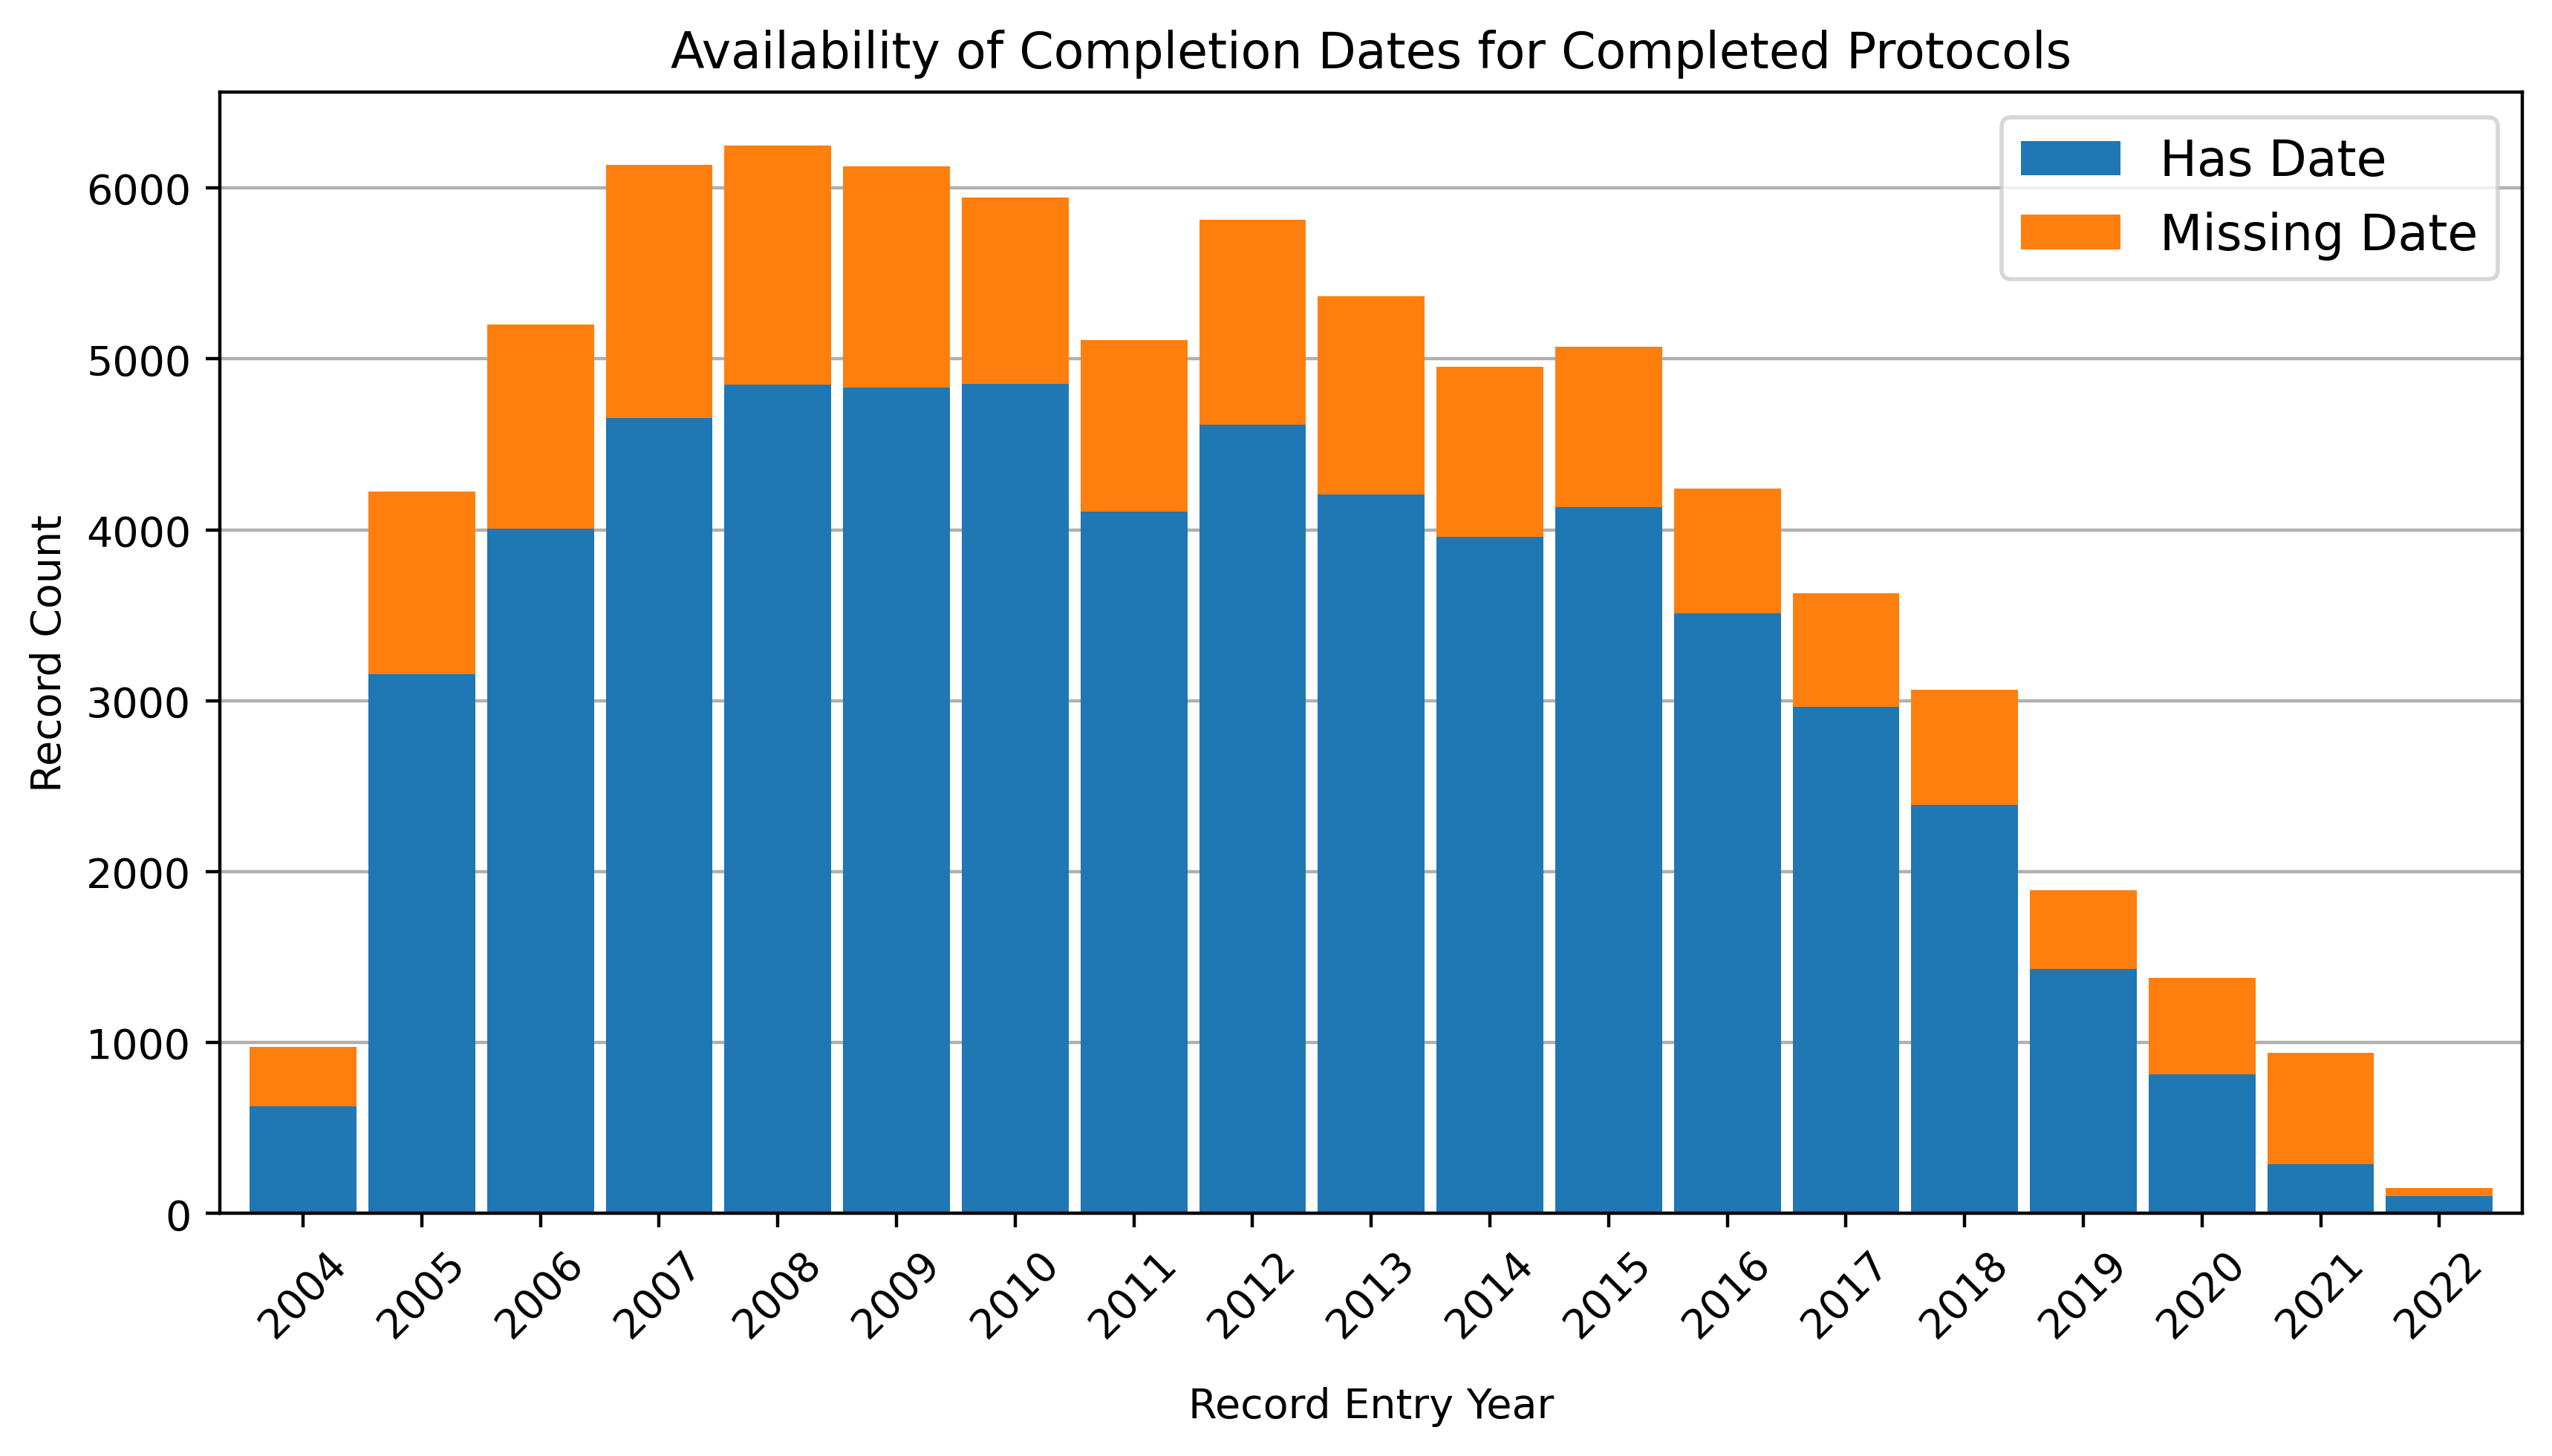

In [39]:
overall_dates = stacked_dates.droplevel(level=0).groupby(stacked_dates.droplevel(level=0).index).sum()

title='Availability of Completion Dates for Completed Protocols'

fig, ax = plt.subplots(figsize = (10,5), dpi=400)
overall_dates.reindex(['numerator', 'missing_dates']).T.plot.bar(stacked=True, width=.9, ax=ax, legend=False, 
                                                                 rot=45, title=title)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Record Entry Year', labelpad=10)
ax.set_ylabel('Record Count')

plt.legend(['Has Date', 'Missing Date'], 
           loc='upper right', fontsize=12)
plt.show()
#fig.savefig(parent + '/data/Figures/fig_s9.jpg', bbox_inches='tight', dpi=400)
#Saved

In [40]:
dates_trans = overall_dates.T
dates_trans['prct'] = dates_trans['numerator'] / (dates_trans['numerator'] + dates_trans['missing_dates'])

In [41]:
print(dates_trans.missing_dates.sum() + dates_trans.numerator.sum())
print(dates_trans.numerator.sum() / (dates_trans.missing_dates.sum() + dates_trans.numerator.sum()))

76468.0
0.7782732646335722


In [42]:
overall_comp_dict = {}

for x in ordered_countries:
    d = stacked_dates.loc[x].T
    num = d.numerator.sum()
    denom = num + d.missing_dates.sum()
    overall_comp_dict[x] = num / denom

rankings_compdate = pd.Series(overall_comp_dict).sort_values(ascending=False)
rankings_compdate

UK - MHRA              0.973817
Poland - URPL          0.921114
Germany - BfArM        0.903384
Croatia - MIZ          0.901695
Portugal - INFARMED    0.875000
Hungary - OGYEI        0.863828
Bulgaria - BDA         0.861738
Norway - NoMA          0.857809
Denmark - DKMA         0.855673
Lithuania - VVKT       0.852502
Austria - BASG         0.850483
Greece - EOF           0.849794
France - ANSM          0.836578
Czechia - SUKL         0.826872
Romania - ANMDM        0.826748
Iceland - IMA          0.823009
Slovakia - SUKL        0.809786
Slovenia - JAZMP       0.803125
Estonia - SAM          0.802376
Finland - FIMEA        0.784804
Sweden - MPA           0.769256
Ireland - HPRA         0.763485
Latvia - ZVA           0.755224
Germany - PEI          0.705333
Spain - AEMPS          0.669827
Belgium - FAMHP        0.586445
Netherlands - CCMO     0.558404
Italy - AIFA           0.447618
dtype: float64

# Trends in completion data availability by country - Supplemental Figure 10

In [43]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=400)
fig.suptitle("Trends in Completion Date Availability by National Regulator", y=1.02, fontsize=23)
fig.tight_layout()

for x, y in enumerate(fig.axes):
    stacked_dates.loc[[rankings_compdate.index[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.85, 
                                                                            legend=False, sharex='col', rot=45)

    y.set_title(rankings_compdate.index[x], pad=6, fontsize=16)
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('')
    
    hatches = ['','//']
    counter = 0
    h_counter = 0
    patch_count = len(y.patches)
    for p in y.patches:
        p.set_hatch(hatches[h_counter])
        counter += 1
        if counter == ((patch_count/2) * (h_counter+1)):
            h_counter += 1
    
fig.text(-0.015, 0.5, 'Record Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.5, -0.02, 'Record Entry Year', ha='center', va='center', fontsize=20)
    
plt.legend(['Has Date', 'Missing Date'], 
           loc='lower center', ncol=5, bbox_to_anchor = (-1.25, -.9), fontsize=15)

plt.show()
fig.savefig(parent + '/data/Figures/fig_s10.jpg', bbox_inches='tight', dpi=400)
#Saved

# Figure 4b

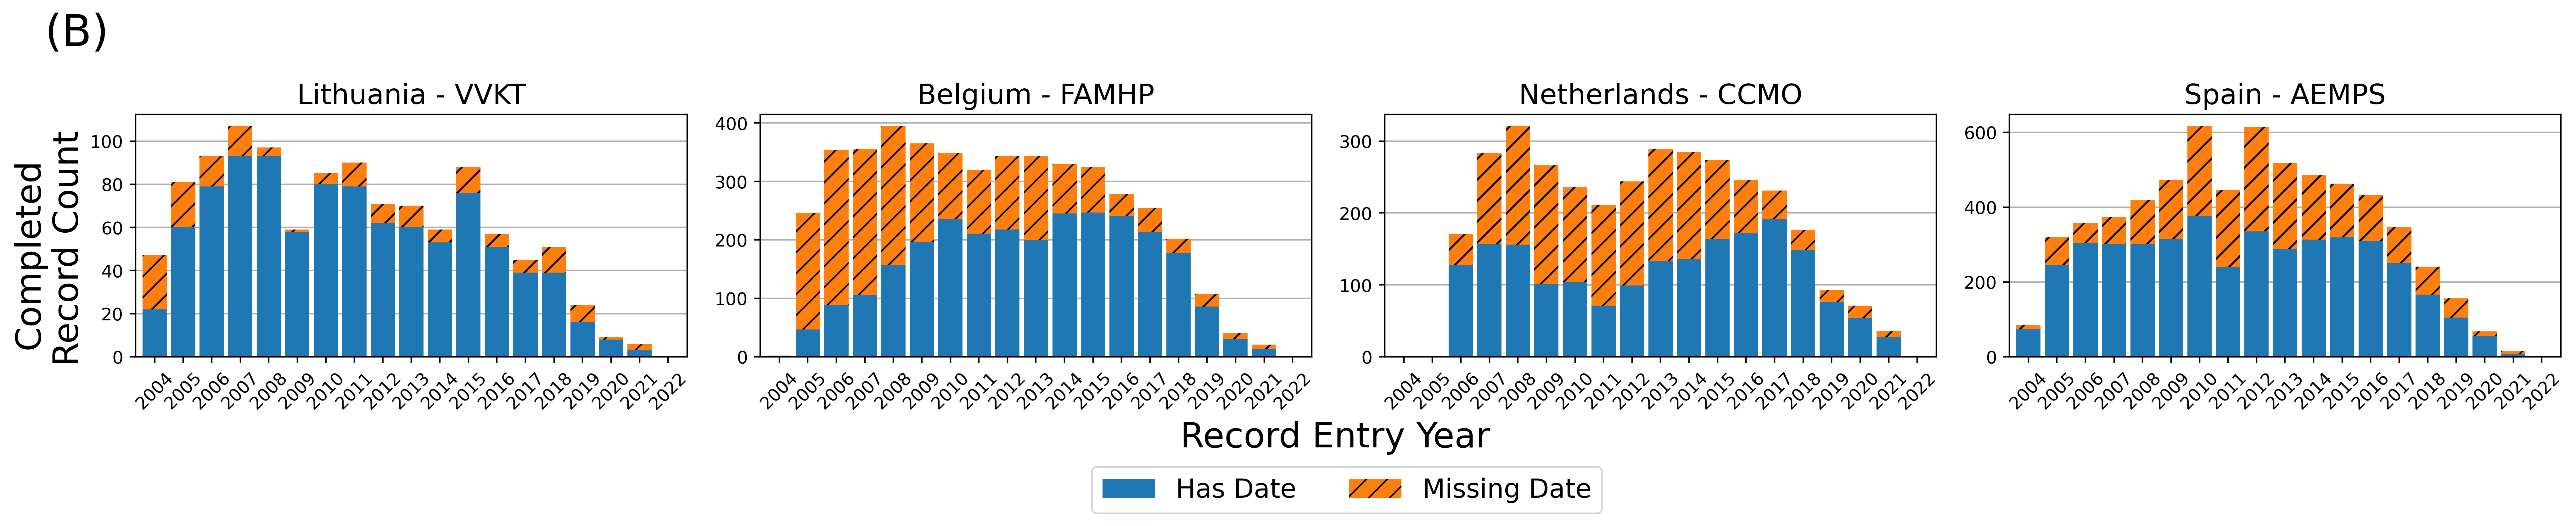

In [44]:
fig, axes = plt.subplots(figsize = (20, 3), nrows=1, ncols=4, dpi=400)
fig.suptitle("(B)", y=1.04, x=0, fontsize=25)
fig.tight_layout()
included_countries = ['Lithuania - VVKT', 'Belgium - FAMHP', 'Netherlands - CCMO', 'Spain - AEMPS']

for x, y in enumerate(fig.axes):
    stacked_dates.loc[[included_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.85, 
                                                                            legend=False, sharex='col', rot=45)

    y.set_title(included_countries[x], pad=6, fontsize=16)
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('')
    
    hatches = ['','//']
    counter = 0
    h_counter = 0
    patch_count = len(y.patches)
    for p in y.patches:
        p.set_hatch(hatches[h_counter])
        counter += 1
        if counter == ((patch_count/2) * (h_counter+1)):
            h_counter += 1
    
fig.text(-.011, 0.4, 'Completed\n Record Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.5, -.087, 'Record Entry Year', ha='center', va='center', fontsize=20)
    
plt.legend(['Has Date', 'Missing Date'], 
           loc='lower center', ncol=5, bbox_to_anchor = (-1.2, -.7), fontsize=15)

plt.show()
#fig.savefig(parent + '/data/Figures/fig_4b.jpg', bbox_inches='tight', dpi=400)
#fig.savefig(parent + '/data/Figures/fig_4b.eps', bbox_inches='tight', dpi=400)
#Saved

# Combining Status and Completion Date (Figure 3)

In [49]:
usecols2 = ['eudract_number', 'nca', 'entered_year', 'trial_status', 'completion_date', 'trial_results']

In [50]:
usecols2 = ['eudract_number', 'nca', 'entered_year', 'trial_status', 'completion_date', 'trial_results']

date_df2 = pd.read_csv(parent + '/data/analysis_df_jul22.csv', usecols=usecols2)
date_df2['trial_status'] = date_df2.trial_status.fillna('Missing')
date_df2['has_completion_date'] = np.where(date_df2.completion_date.isna(), 0, 1)

In [51]:
total_trials = date_df2[['nca', 
                         'entered_year', 
                         'has_completion_date']].groupby(['nca', 
                                                          'entered_year']).count().rename({'has_completion_date': 'denominator'}, axis=1)

total_trials_date = only_completed[['nca', 'entered_year', 'has_completion_date']].groupby(['nca', 'entered_year']).sum().rename({'has_completion_date': 'numerator'}, axis=1)

merged_dates2 = total_trials.join(total_trials_date)
merged_dates2['missing_dates'] = merged_dates2.denominator - merged_dates2.numerator

stacked_dates2 = merged_dates2.drop('denominator', axis=1).stack().unstack(1)
stacked_dates2.head()

entered_year                   2004   2005   2006   2007   2008   2009   2010  \
nca                                                                             
Austria - BASG  numerator      75.0  213.0  204.0  216.0  286.0  228.0  255.0   
                missing_dates  35.0   60.0   72.0   62.0   68.0   32.0   47.0   
Belgium - FAMHP numerator       2.0   47.0   88.0  106.0  157.0  197.0  236.0   
                missing_dates   0.0  216.0  314.0  294.0  270.0  214.0  153.0   
Bulgaria - BDA  numerator       NaN    1.0    NaN   20.0  116.0  111.0  115.0   

entered_year                    2011   2012   2013   2014   2015   2016  \
nca                                                                       
Austria - BASG  numerator      242.0  223.0  225.0  183.0  180.0  141.0   
                missing_dates   35.0   41.0   59.0   55.0   77.0   73.0   
Belgium - FAMHP numerator      211.0  218.0  200.0  245.0  247.0  241.0   
                missing_dates  142.0  169.0  224.0  168.0  183.0  136.0   
Bulgaria - BDA  numerator      136.0  158.0  140.0  127.0  127.0  125.0   

entered_year                    2017   2018   2019   2020   2021  2022  
nca                                                                     
Austria - BASG  numerator      119.0  107.0   57.0   31.0    7.0   NaN  
                missing_dates   94.0  128.0  142.0  177.0  170.0   NaN  
Belgium - FAMHP numerator      214.0  178.0   86.0   30.0   14.0   NaN  
                missing_dates  168.0  212.0  201.0  192.0  255.0   NaN  
Bulgaria - BDA  numerator      135.0  100.0   57.0   45.0   14.0   NaN

In [52]:
total_comp_dict = {}

for x in ordered_countries:
    d = stacked_dates2.loc[x].T
    num = d.numerator.sum()
    denom = num + d.missing_dates.sum()
    total_comp_dict[x] = num / denom

rankings_compdate2 = pd.Series(total_comp_dict).sort_values(ascending=False)

In [53]:
props_for_graph = rankings_completed.to_frame(name='prct_completed').join(rankings_compdate2.to_frame(name='prct_date'))
props_for_graph['diff1'] = props_for_graph.prct_completed - props_for_graph.prct_date
props_for_graph['diff2'] = 1 - props_for_graph.prct_completed

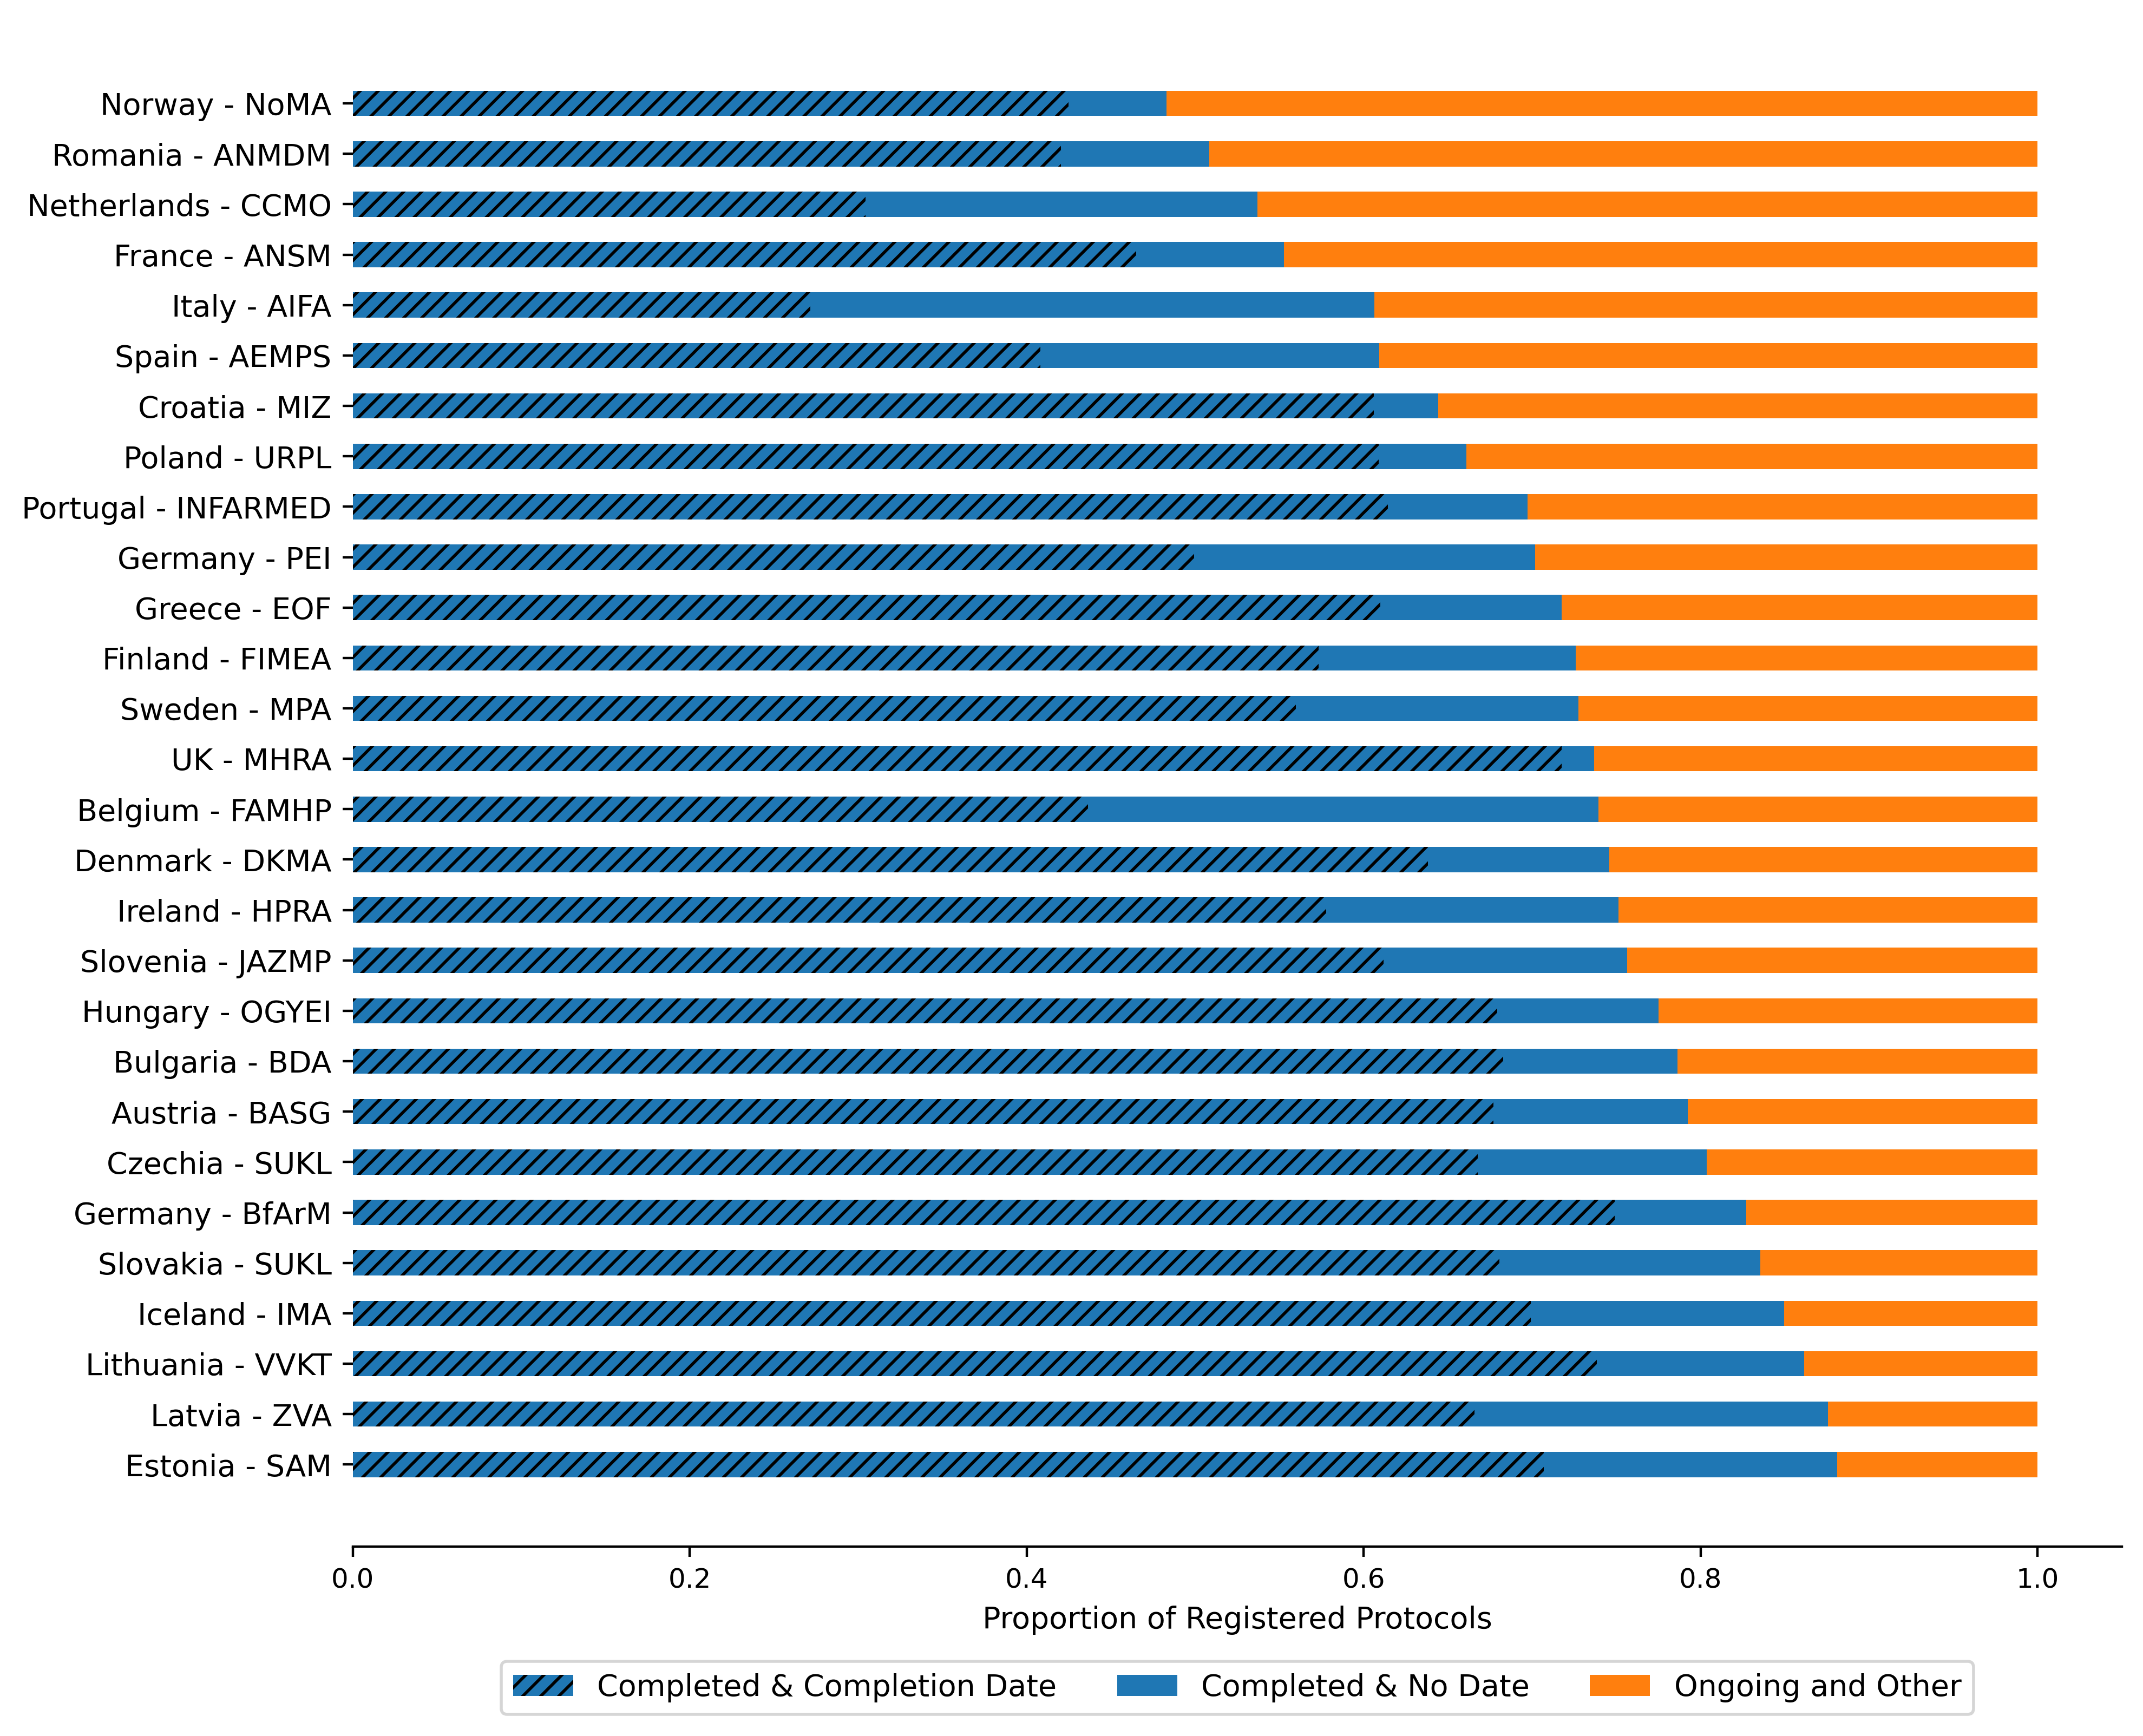

In [54]:
fig = plt.figure(figsize = (10,8), dpi=400)
ax = fig.add_subplot(111)

ax.barh(props_for_graph.index, props_for_graph.prct_date, align='center', height=.5, color='C0', hatch='////', label='Completed & Completion Date')
ax.barh(props_for_graph.index, props_for_graph.diff1, align='center', height=.5, color='C0', left=props_for_graph.prct_date, label='Completed & No Date')
ax.barh(props_for_graph.index, props_for_graph.diff2, align='center', height=.5, color='C1', left=props_for_graph.prct_completed, label = 'Ongoing and Other')
ax.set_xlabel('Proportion of Registered Protocols')
ax.tick_params(axis='x', labelsize=9)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=3, loc='lower center', bbox_to_anchor = (.5, -.12))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.title('')
plt.tight_layout()
plt.show()
#fig.savefig(parent + '/data/Figures/fig_3.jpg', bbox_inches='tight', dpi=400)
#fig.savefig(parent + '/data/Figures/fig_3.eps', bbox_inches='tight', dpi=400)
#Saved

# Stat on conflicting dates

In [55]:
grouped_dates_count = date_df[['eudract_number', 'completion_date']].groupby('eudract_number').agg({'eudract_number': ['count'], 'completion_date': ['nunique', 'count']})

In [56]:
has_dates = grouped_dates_count[grouped_dates_count.completion_date['count'] > 1]

In [57]:
#Filters
all_have_dates = (has_dates.eudract_number['count'] == has_dates.completion_date['count'])
consistant_dates = has_dates.completion_date['nunique'] == 1

In [58]:
print(f'{round((len(has_dates[all_have_dates & consistant_dates])/len(has_dates)) * 100,2)}% of all trials with multiple protocols and at least one completion date are consistent across all protocols')

27.33% of all trials with multiple protocols and at least one completion date are consistent across all protocols
